In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.image as mpimg
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.patches as patches
import os
import math
from os import listdir
from os.path import isfile, join
from PIL import Image
from torch.autograd import Variable
import cv2

def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Directories

In [6]:
start_dir = "/home/paperspace/zen/"

cufs_imgs_dir = start_dir + "CIS-680-Final-Project/HW3/data/cufs/imgs/"

In [53]:
class cufs_Data(Dataset):
    __xs = []
    __ys = []

    def __init__(self, folder_dataset, transform=None):
        self.transform = transform
        # Open and load text file including the whole training data
        with open(folder_dataset + "data.txt") as f:
            for line in f:
                self.__xs.append(folder_dataset + line.strip())

    # Override to give PyTorch access to any image on the dataset
    def __getitem__(self, index):
        img = Image.open(self.__xs[index])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        # Convert image and label to torch tensors
        img = torch.from_numpy(np.asarray(img))
        return img, []

    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.__xs)

In [54]:
files = os.listdir(cufs_imgs_dir)
imgs = [i for i in files if i.endswith("png")]

np.random.seed(0)
num_train = len(imgs)
indices = list(range(num_train))
split = int(num_train/5)

# Random, non-contiguous split
test_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

transform_img = transforms.Compose(
    [transforms.ToTensor()])
dset_train = cufs_Data(cufs_imgs_dir, transform = transform_img)
train_loader = DataLoader(dset_train, batch_size=10, shuffle=False, num_workers=1, sampler=train_sampler)
test_loader = DataLoader(dset_train, batch_size=10, shuffle=False, num_workers=1, sampler=test_sampler)

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8cf461fe48>>
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/paperspace/anaconda3/envs/cv/lib/pytho

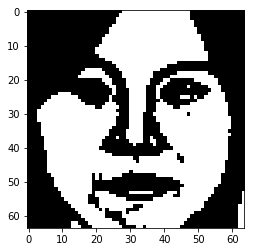

In [55]:
dataiter = iter(train_loader)
inputs, _ = dataiter.next()
img = np.transpose(inputs[0].numpy(), (1,2,0))
plt.imshow(img)

In [61]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

epochs = 100
batch_size = 10
log_interval = 1000

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(12288, 4000)
        self.fc21 = nn.Linear(4000, 200)
        self.fc22 = nn.Linear(4000, 200)
        self.fc3 = nn.Linear(200, 4000)
        self.fc4 = nn.Linear(4000, 12288)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 12288))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 12288), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 3, 64, 64)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 200).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 3, 64, 64),
                   'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/188 (0%)]	Loss: 8613.848438
====> Epoch: 1 Average loss: 5741.0070
====> Test set loss: 1073.7242
Train Epoch: 2 [0/188 (0%)]	Loss: 5232.779688
====> Epoch: 2 Average loss: 4180.2595
====> Test set loss: 987.7456
Train Epoch: 3 [0/188 (0%)]	Loss: 5073.096875
====> Epoch: 3 Average loss: 3757.7526
====> Test set loss: 872.0054
Train Epoch: 4 [0/188 (0%)]	Loss: 4209.042969
====> Epoch: 4 Average loss: 3459.3665
====> Test set loss: 850.2905
Train Epoch: 5 [0/188 (0%)]	Loss: 4335.988672
====> Epoch: 5 Average loss: 3294.6319
====> Test set loss: 807.9850
Train Epoch: 6 [0/188 (0%)]	Loss: 4032.567578
====> Epoch: 6 Average loss: 3120.6577
====> Test set loss: 822.0522
Train Epoch: 7 [0/188 (0%)]	Loss: 3679.176562
====> Epoch: 7 Average loss: 3000.2609
====> Test set loss: 803.6178
Train Epoch: 8 [0/188 (0%)]	Loss: 3483.657813
====> Epoch: 8 Average loss: 2888.7748
====> Test set loss: 791.4803
Train Epoch: 9 [0/188 (0%)]	Loss: 3343.694922
====> Epoch: 9 Average loss: 2746

====> Test set loss: 1474.1329
Train Epoch: 72 [0/188 (0%)]	Loss: 2069.851367
====> Epoch: 72 Average loss: 1605.3813
====> Test set loss: 1408.6956
Train Epoch: 73 [0/188 (0%)]	Loss: 1721.202344
====> Epoch: 73 Average loss: 1320.7569
====> Test set loss: 1649.5007
Train Epoch: 74 [0/188 (0%)]	Loss: 1416.256934
====> Epoch: 74 Average loss: 1027.8599
====> Test set loss: 1766.0049
Train Epoch: 75 [0/188 (0%)]	Loss: 1295.811328
====> Epoch: 75 Average loss: 767.0739
====> Test set loss: 1523.5969
Train Epoch: 76 [0/188 (0%)]	Loss: 587.471582
====> Epoch: 76 Average loss: 548.1628
====> Test set loss: 1488.2044
Train Epoch: 77 [0/188 (0%)]	Loss: 565.103906
====> Epoch: 77 Average loss: 380.8459
====> Test set loss: 1540.3467
Train Epoch: 78 [0/188 (0%)]	Loss: 427.081787
====> Epoch: 78 Average loss: 297.8801
====> Test set loss: 1671.0187
Train Epoch: 79 [0/188 (0%)]	Loss: 303.020386
====> Epoch: 79 Average loss: 259.6896
====> Test set loss: 1651.3196
Train Epoch: 80 [0/188 (0%)]	Loss: